In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# K-Nearest Neighbor (KNN): Brute-force

## Index

1. [Setup](#setup)
2. [Data Analysis](#data-analysis)
3. [Implement KNN Algorithm](#implement-knn-algorithm)
4. [Model Training](#model-training)
5. [Hyperparameter Tuning](#hyperparameter-tuning)
6. [Performance Metrics](#performance-metrics)
7. [Conclusion](#conclusion)

### Objective

1. Understanding KNN algorithm.
2. **Implement KNN** algorithm without scikit-learn.
3. Given a query point <code>x<sub>q</sub></code>, **predict** its class using KNN.
4. Implement **Estimator (Accuracy/Error)** for KNN algorithm.
5. Implement **Random Search CV** for hyperparameter tuning without scikit-learn.

> <font color="red"><b>KNN implementation is NOT production quality (just for learning purpose only)!</b></font>

<a id="setup"></a>
## [1] Setup

### Import and configure required libraries

In [2]:
# Data manipulation libraries
import numpy as np
from numpy import random
import scipy as sp
from scipy.ndimage import gaussian_filter1d
import pandas as pd

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Data modeling Libraries
import sklearn as sk
from sklearn.datasets import make_classification
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

# General imports
import math
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# Library versions used in below EDA.
print("NumPy version:", np.__version__)
print("SciPy version:", sp.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-Learn version:", sk.__version__)

# Configure NumPy.
# Set `Line width` to Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.2)  # Set font to scale 1.5 more than normal.

NumPy version: 1.21.5
SciPy version: 1.7.3
Pandas version: 1.4.3
Matplotlib version: 3.5.2
Seaborn version: 0.11.2
Scikit-Learn version: 1.1.1


<IPython.core.display.Javascript object>

#### Helper functions

In [3]:
def is_empty(var) -> bool:
    """
    Function to check if input variable `var` is empty.

    Other than some special exclusions and inclusions,
    this function returns boolean result of Falsy check.
    """
    if (isinstance(var, int) or isinstance(var, float)) and var == 0:
        # Exclude 0 and 0.0 from the Falsy set.
        return False
    elif isinstance(var, str) and len(var.strip()) == 0:
        # Include string with only one or more empty space(s) into Falsy set.
        return True
    elif isinstance(var, bool):
        # Exclude False from the Falsy set.
        return False
    else:
        # Falsy check.
        return False if var else True


def all_zeros(numbers):
    """
    Function to check if all items in the list are zero.
    """
    return all(n == 0 for n in numbers)


def groupby_count(items, get_key):
    """
    Function to count `key` in a list of items.
    """
    count = {}
    for index, item in enumerate(items):
        key_name = get_key(item)
        if is_empty(key_name):
            raise ValueError(f"Specified key: `{key_name}` not found in the item at index: `{index}` in the list.")

        count[key_name] = count.get(key_name, 0) + 1

    return count


smooth = lambda dist, sigma=1: gaussian_filter1d(dist, sigma)


ENABLE_LOG = False


def title(title_str, padding=[1, 1], line_style="="):
    """
    Function to print() input string with some styles, when logging is enabled.
    """
    if ENABLE_LOG is True:
        pad_top, pad_bot = padding
        pt = "\n" * pad_top
        pb = "\n" * pad_bot
        print(pt + title_str + "\n" + line_style * len(title_str) + pb)


def text(*args):
    """
    Function to print() input string when logging is enabled.
    """
    if ENABLE_LOG is True:
        print(*args)


print("Loading common functions done!")

Loading common functions done!


<IPython.core.display.Javascript object>

#### Plotting functions

In [4]:
def class_subplots(params):
    fig, ax = plt.subplots(1, 2, figsize=(11, 3))

    if params.get("suptitle", None):
        fig.suptitle(params["suptitle"])

    sns.scatterplot(ax=ax[0], data=params["df_c0"], x="Feature 1", y="Feature 2", hue="Class")
    ax[0].set_title(params.get("ax0_title", "Class 0"))
    ax[0].set_xticks(ticks=np.arange(f1_min, f1_max + 1, 1))
    ax[0].set_yticks(ticks=np.arange(f2_min, f2_max + 1, 1))

    sns.scatterplot(ax=ax[1], data=params["df_c1"], x="Feature 1", y="Feature 2", hue="Class")
    ax[1].set_title(params.get("ax1_title", "Class 1"))
    ax[1].set_xticks(ticks=np.arange(f1_min, f1_max + 1, 1))
    ax[1].set_yticks(ticks=np.arange(f2_min, f2_max + 1, 1))

    plt.show()

<IPython.core.display.Javascript object>

### Generate data-points using `sklearn`

In [5]:
X, y = make_classification(
    n_samples=2350,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=60,
)

df = pd.DataFrame(data=np.hstack((X, y.reshape(X.shape[0], 1))), columns=["Feature 1", "Feature 2", "Class"])
df["Class"] = df["Class"].astype("category")

rows, cols = df.shape

df.head()

,Feature 1,Feature 2,Class
0,-0.943044,0.922699,0.0
1,-1.920080,1.556398,0.0
2,-0.849563,-0.016211,1.0
3,-1.395698,-0.839997,1.0
4,-1.069196,0.752136,0.0


<IPython.core.display.Javascript object>

<a id="data-analysis"></a>
## [2] Data Analysis

In [6]:
ENABLE_LOG = True

title("Features")
text("Features shape:", X.shape)

title("Class Labels")
text("Class-labels shape:", y.shape)
(cl1, cl2), (cl1_count, cl2_count) = np.unique(y, return_counts=True)
text(f"Class 1: '{cl1}', Count:", cl1_count)
text(f"Class 2: '{cl2}', Count:", cl2_count)

f1_max = math.ceil(np.max(X[:, 0]))
f1_min = math.floor(np.min(X[:, 0]))
title("Feature 1")
text("Max value:", f1_max, "\nMin value:", f1_min)

f2_max = math.ceil(np.max(X[:, 1]))
f2_min = math.floor(np.min(X[:, 1]))
title("Feature 2")
text("Max value:", f2_max, "\nMin value:", f2_min)


Features

Features shape: (2350, 2)

Class Labels

Class-labels shape: (2350,)
Class 1: '0', Count: 1177
Class 2: '1', Count: 1173

Feature 1

Max value: 3 
Min value: -6

Feature 2

Max value: 4 
Min value: -4


<IPython.core.display.Javascript object>

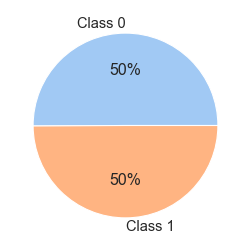

<IPython.core.display.Javascript object>

In [7]:
labels = ["Class 0", "Class 1"]
colors = ["#a1c9f4", "#ffb482"]

plt.figure(figsize=(3, 3))
plt.pie(x=[cl1_count, cl2_count], labels=labels, colors=colors, autopct="%1.0f%%")
plt.show()

**Dataset is well Balanced!**

### Plot data-points

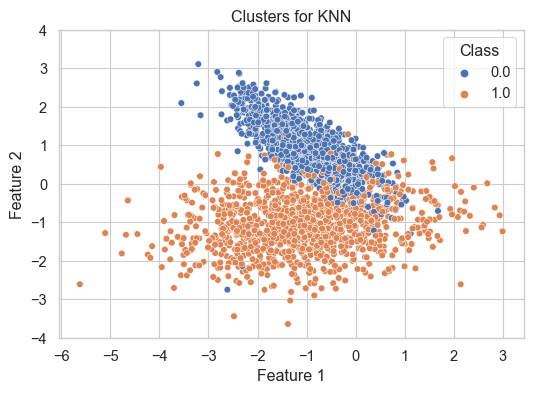

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(6, 4))  # Width, Height

sns.scatterplot(data=df, x="Feature 1", y="Feature 2", hue="Class")
plt.title("Clusters for KNN")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xticks(ticks=np.arange(f1_min, f1_max + 1, 1))
plt.yticks(ticks=np.arange(f2_min, f2_max + 1, 1))

plt.show()

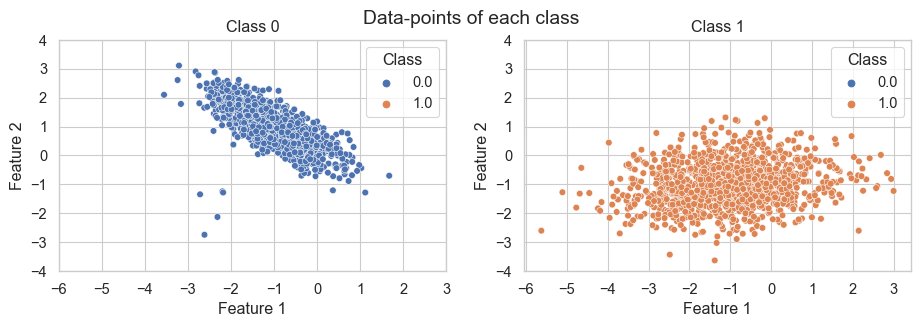

<IPython.core.display.Javascript object>

In [9]:
fltr = df["Class"] == 0

class_subplots(
    {
        "suptitle": "Data-points of each class",
        "df_c0": df[fltr],
        "df_c1": df[~fltr],
    }
)

### Detecting Outliers

#### Local Outlier Factor (LOF)

In [10]:
clf = LocalOutlierFactor(n_neighbors=20)

df["LOA"] = clf.fit_predict(X)
df["NOA"] = clf.negative_outlier_factor_

print("Sample rows to show new columns: LOA and NOA.")
df.head()

Sample rows to show new columns: LOA and NOA.


,Feature 1,Feature 2,Class,LOA,NOA
0,-0.943044,0.922699,0.0,1,-1.008977
1,-1.920080,1.556398,0.0,1,-0.994948
2,-0.849563,-0.016211,1.0,1,-1.186370
3,-1.395698,-0.839997,1.0,1,-0.984446
4,-1.069196,0.752136,0.0,1,-0.998929


<IPython.core.display.Javascript object>

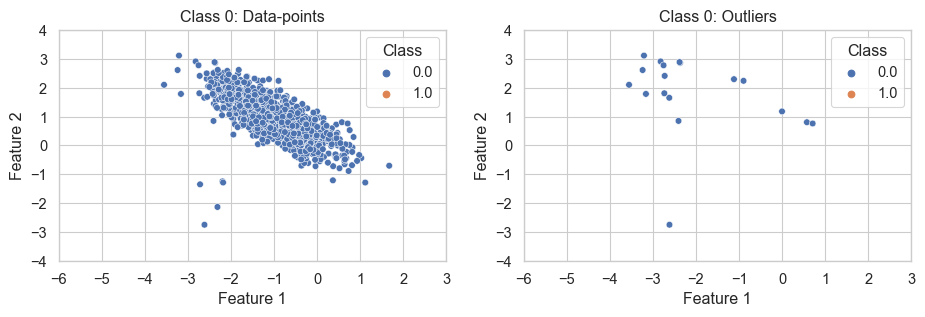

<IPython.core.display.Javascript object>

In [11]:
fltr1 = df["Class"] == 0
fltr2 = fltr1 & (df["LOA"] == -1)
# fltr2 = fltr1 & (df["NOA"] < -1.5)

class_subplots(
    {
        "df_c0": df[fltr1],
        "df_c1": df[fltr2],
        "ax0_title": "Class 0: Data-points",
        "ax1_title": "Class 0: Outliers",
    }
)

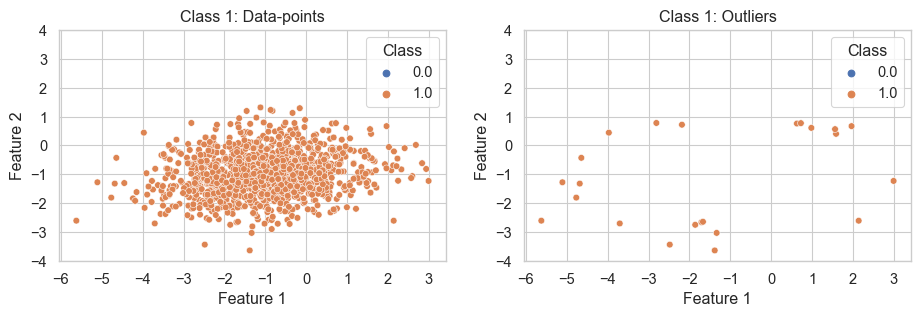

<IPython.core.display.Javascript object>

In [12]:
fltr1 = df["Class"] == 1
fltr2 = fltr1 & (df["LOA"] == -1)
# fltr2 = fltr1 & (df["NOA"] < -1.5)

class_subplots(
    {
        "df_c0": df[fltr1],
        "df_c1": df[fltr2],
        "ax0_title": "Class 1: Data-points",
        "ax1_title": "Class 1: Outliers",
    }
)

### Delete Outliers

In [13]:
fltr = df["LOA"] == -1

print("Number of outliers found:", len(df[fltr]))
print("Before:", df.shape)
df.drop(index=df[fltr].index, inplace=True)
print("After:", df.shape)

Number of outliers found: 41
Before: (2350, 5)
After: (2309, 5)


<IPython.core.display.Javascript object>

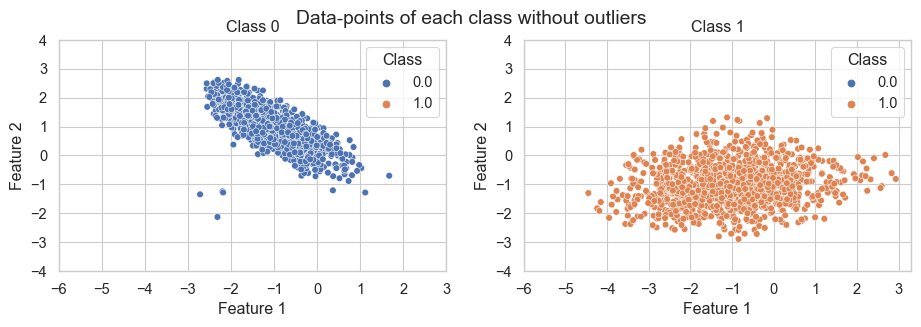

<IPython.core.display.Javascript object>

In [14]:
fltr = df["Class"] == 0

class_subplots(
    {
        "suptitle": "Data-points of each class without outliers",
        "df_c0": df[fltr],
        "df_c1": df[~fltr],
    }
)

<a id="implement-knn-algorithm"></a>
## [3] Implement KNN Algorithm

1. `D` := Represents entire dataset 
2. `n` := Total number of data-points.
3. `d` := Total number of features.
4. `x_q` := Query Point.

* **STEP 1:** Find `K` nearest points to <code>x<sub>q</sub></code> in `D`.
    * For each data-point <code>x<sub>i</sub></code> in `D` calculate the distance between <code>x<sub>q</sub></code> and <code>x<sub>i</sub></code>.
    * Sort the data-points in increasing order of their distance from <code>x<sub>q</sub></code>.
    * Say `k = 3` and take first three nearest points and store it in `knn`, for example `knn = {x5, x2, x7}`.
* **STEP 2:** Take majority vote of class-labels.
    * Get class-labels of all data-points in `knn` from _STEP 1_ and store it in `y_p`, for example `y_p = {y5, y2, y7}`.
    * Take class-label with highest occurrence in `y_p` and store it in `y_q`.
    * Declare <code>x<sub>q</sub></code> belongs to class `y_q`.

> **Note:**
> 1. If there are equal number of points from all the classes in `y`, it can create confusion while voting.
> 2. To avoid confusion in voting, `K` should preferably be **odd number**.
> 3. Its considered good practice to take `K` value as $\sqrt{N)}$.

There are different techniques available to calculate distance between two points:

1. **Euclidean Distance**: The L2 Norm.
2. **Manhattan Distance**: The L1 Norm.
3. **Minkowski Distance**: Lp Norm, where p > 0.
    1. If p = 1, Minkowski Distance is same as _Manhattan Distance_.
    2. If p = 2, Minkowski Distance is same as _Euclidean Distance_.
4. **Hamming Distance**
    1. Hamming Distance is mostly used in text processing.
    2. Useful to find distance b/w binary vectors (for example, binary BOW).
    3. Useful in Gene Sequencing.
5. **Cosine Distance**
    1. Cosine similarity is inversely proportional to Cosine distance.
    2. $\text {Cosine distance} = 1 - \text {Cosine similarity}$
    3. Two points are **similar** if **cosine similarity = 1**, then the **cosine distance = 0** (least possible distance).
    4. Two points are **dissimilar** if **cosine similarity = -1**, then the **cosine distance = 2** (maximum possible distance).

> **Note:**  
> **Distances** are always between two points whereas **Norm** is for vectors.

In [15]:
def cosine_similarity(p1, p2):
    """
    Function to compute Cosine Distance between two points.
    """
    if all_zeros(p1) or all_zeros(p2):
        return 0

    dot_prod = (p1[0] * p2[0]) + (p1[1] * p2[1])
    p1_mag = math.sqrt(p1[0] ** 2 + p1[1] ** 2)
    p2_mag = math.sqrt(p2[0] ** 2 + p2[1] ** 2)

    return dot_prod / (p1_mag * p2_mag)


# Function to compute Cosine Distance between two points.
cosine_distance = lambda p1, p2: 1 - cosine_similarity(p1, p2)


def minkowski_distance(p1, p2, p=3):
    """
    Function to compute Minkowski Distance between two points.
    """
    diff = abs(p1[0] - p2[0]) ** p + abs(p1[1] - p2[1]) ** p
    return math.pow(diff, 1 / p)


# Function to compute Manhattan Distance between two points.
manhattan_distance = lambda p1, p2: minkowski_distance(p1, p2, p=1)

# Function to compute Euclidean Distance between two points.
euclidean_distance = lambda p1, p2: minkowski_distance(p1, p2, p=2)

<IPython.core.display.Javascript object>

### Implementation

In [16]:
def KNNClassifier(X, Y):
    """
    Function to prepare training and testing data before applying KNN algorithm.
    """

    # Default values
    DFLT_K = 5
    DIST_ALGO = 1
    PRECISION = 6

    def get_k_nearest_points(X, x_q, K=DFLT_K, algo_type=DIST_ALGO):
        """
        Closure to return `K` nearest data-points to query-point `x_q`.
        """
        if K <= 0:
            raise ValueError("K must be an integer greater than zero.")

        if algo_type == 1:
            text("Computing Euclidean Distance.")
            algo = euclidean_distance
        elif algo_type == 2:
            text("Computing Manhattan Distance.")
            algo = manhattan_distance
        elif algo_type == 3:
            text("Computing Minkowski Distance.")
            algo = minkowski_distance
        elif algo_type == 4:
            text("Computing Cosine Distance.")
            algo = cosine_distance
        else:
            raise ValueError(f"Invalid `algo_type` {algo_type}. Value should be in {1, 2, 3, 4}.")

        distances = []
        for idx, x in enumerate(X):
            label = str(Y[idx])
            distance = round(algo(x, x_q), PRECISION)
            distances.append([label, distance])

        text(f"Returning {K} nearest neighbors.")
        return sorted(distances, key=lambda x: x[1])[:K]

    def majority_vote(knn):
        """
        Closure to take majority vote of class-labels.
        """
        if is_empty(knn):
            raise ValueError("Class list is empty.")

        # Get class-labels of all data-points and take majority vote/count.
        cl_count = groupby_count(knn, lambda n: n[0])
        text("Class-labels count:", cl_count)

        # Sort class-labels by count.
        cl_sorted = sorted(cl_count.items(), key=lambda x: x[1], reverse=True)
        text("Class-labels sorted:", cl_sorted)

        # Return class-label with highest count as `y_q`.
        return cl_sorted[0]

    def predict(x_q, K=DFLT_K, algo_type=DIST_ALGO):
        """
        Closure to predict class-label based on `K` nearest neighbor.
        Apply KNN algorithm on query point `x_q` for given `K` value.
        """
        # STEP 1: Get K-nearest neighbors.
        knn = get_k_nearest_points(X, x_q, K, algo_type)

        # STEP 2: Get class with majority votes.
        return majority_vote(knn)  # Predicted class label and its votes

    return predict

<IPython.core.display.Javascript object>

<a id="model-training"></a>
## [4] Model Training

### How to measure the effectiveness of an Algorithm?

To measure the effectiveness of an algorithm, 

1. Split the dataset randomly into **Train** and **Test** datasets.
2. **Model Training**: Apply the **algorithm on Train** dataset.
3. **Model Testing**: Predict target (class-label) using each data-point from Test dataset.
4. **Performance Metrics**: Measure the effectiveness of **Model Training** by comparing the predicted class-labels with actual class-labels in Test dataset.

### Split the dataset into Train and Test.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

title("Training Dataset")
text("Features shape:", X_train.shape)
text("Class-labels shape:", y_train.shape)

title("Training Dataset")
text("Features shape:", X_test.shape)
text("Class-labels shape:", y_test.shape)


Training Dataset

Features shape: (1645, 2)
Class-labels shape: (1645,)

Training Dataset

Features shape: (705, 2)
Class-labels shape: (705,)


<IPython.core.display.Javascript object>

### Base Model: Apply KNN

In [18]:
ENABLE_LOG = True

predict = KNNClassifier(X_train, y_train)

pcl, nn = predict(x_q=(0.2, -0.6), K=50, algo_type=1)

print("\nPredicted class label:", pcl)
print("Nearest neighbors:", nn)

Computing Euclidean Distance.
Returning 50 nearest neighbors.
Class-labels count: {'0': 9, '1': 41}
Class-labels sorted: [('1', 41), ('0', 9)]

Predicted class label: 1
Nearest neighbors: 41


<IPython.core.display.Javascript object>

In [19]:
def knn_estimator(predict, X_test, y_test, K=5, error=False):
    """
    An Estimator function that returns accuracy score
    or error (if `error` parameter is passed as True).
    """
    pcl_count = 0  # Correctly predicted class-label count.
    for idx, x_q in enumerate(X_test):  # Index, Query-point.
        acl = y_test[idx]  # Actual class label

        # Predicted class-label and its votes
        pcl, count = predict(x_q, K)

        # Compare prediction with actual class-label.
        if str(acl) == str(pcl):
            # Predicted class-label is same as actual class-label.
            pcl_count += 1

    accuracy = pcl_count / len(X_test)
    # Return Training error if metric_type is `error` else return Accuracy.
    return 1 - accuracy if error else accuracy

<IPython.core.display.Javascript object>

### Model Accuracy

In [20]:
ENABLE_LOG = False

predict = KNNClassifier(X_train, y_train)

K_range = range(1, 500, 10)
acc_k = []
for K in tqdm(K_range):
    acc = knn_estimator(predict, X_test, y_test, K)
    acc_k.append((round(acc, 3), K))

100%|██████████| 50/50 [02:30<00:00,  3.01s/it]


<IPython.core.display.Javascript object>

### Plot Accuracy

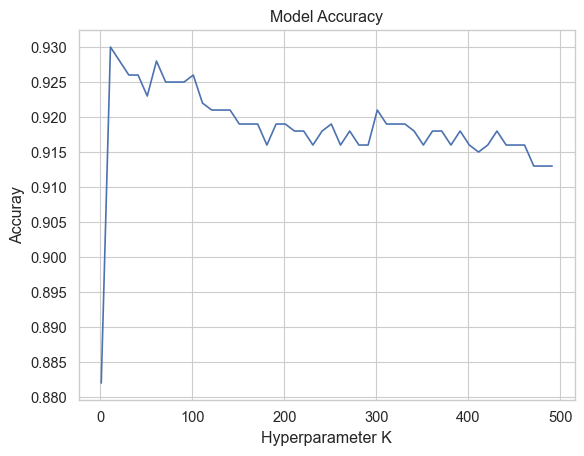

<IPython.core.display.Javascript object>

In [21]:
x_cords = [K for _, K in acc_k]
y_cords = [acc for acc, _ in acc_k]

sns.lineplot(x=x_cords, y=y_cords)
plt.title("Model Accuracy")
plt.xlabel("Hyperparameter K")
plt.ylabel("Accuray")
plt.yticks(ticks=np.arange(0.88, 0.93, 0.005))

plt.show()

In [22]:
acc, K = sorted(acc_k, key=lambda i: i[0], reverse=True)[0]

print(f"Highest accuracy, {acc} recorded for K={K}")

Highest accuracy, 0.93 recorded for K=11


<IPython.core.display.Javascript object>

<font color="red"><b>K=11 might be overfitting the model with misleading high accuracy value 0.93!</b></font>

<a id="hyperparameter-tuning"></a>
## [5] Hyperparameter Tuning

### Need for a Cross-Validation dataset?

1. **Reduce Generalization error** (or improve Generalization accuracy).
2. Tuning hyperparameters to **avoid Underfitting & Overfitting**.

### K-Fold Cross Validation

#### Why default `folds = 5`?

By splitting training dataset (`X_train`) into five folds, one of the fold with approximately **20% data-points** can be used as **Cross-validation dataset** and remaining **80% data-points** as **Training dataset**.

In [23]:
def knn_randomized_search_CV(ftrs, cls_lbls, K_range, folds=5, n_iter=10):
    """
    Function to implement RandomizedSearchCV for KNN algorithm.

    Following hyperparameters are randomized:
        1. K: Number of neighbors used in class-label voting.
        2. CV-dataset: Which Cross-validation dataset to pick after K-folding.
    """

    # Validations.
    if not n_iter > 0:
        raise ValueError("`n_iter` must be greater than zero.")

    k_min, k_max = K_range

    if n_iter > k_max:
        raise ValueError("Number of iterations cannot be greater than K-range.")

    # Generate random `n_iter` number of unique K values b/w [k_min, k_max + 1].
    K_vals = random.choice(range(k_min, k_max + 1), size=n_iter, replace=False)
    K_vals = np.sort(K_vals).tolist()

    # Combine features and class-labels before folding.
    data_set = np.column_stack((ftrs, cls_lbls))

    # Split dataset into `folds` number of folds.
    splits = np.array_split(data_set, folds)
    text(f"Training dataset is split into {folds} folds.")

    k_folds = []
    for idx, split in enumerate(splits):
        # Delete the current split from the list of splits.
        rmng_splits = np.delete(splits, idx, axis=0)

        # Concatenate remaining splits into Training dataset.
        train = np.concatenate(rmng_splits, axis=0)

        # Use current split as Cross-Validation dataset.
        k_folds.append([train, split])  # Training dataset, CV dataset.

    # `k_folds` now contains `folds` number of [Tain, CV] dataset pairs.

    def fit(estimator):
        """
        Closure to fit hyperparameters on Train and Cross-validation dataset.
        """
        mtrn_scrs = []
        mtst_scrs = []
        p_bar = tqdm(K_vals)  # Progress bar
        for K in p_bar:
            trn_scrs = []
            tst_scrs = []
            for fold_idx, k_fold in enumerate(k_folds):
                train, cv = k_fold

                # Prepare Training and Cross-validation dataset.
                X_train = train[:, 0:-1]
                y_train = train[:, -1]
                X_test = cv[:, 0:-1]
                y_test = cv[:, -1]

                # Training KNN classifier.
                predict = KNNClassifier(X_train, y_train)

                # Compute training error.
                p_bar.set_description(f"Train error: K={K}, split #{fold_idx}")
                trn_scrs.append(estimator(predict, X_train, y_train, K, True))

                # Compute testing error.
                p_bar.set_description(f" Test error: K={K}, split #{fold_idx}")
                tst_scrs.append(estimator(predict, X_test, y_test, K, True))

            mtrn_scrs.append(np.mean(trn_scrs))
            mtst_scrs.append(np.mean(tst_scrs))

        return (mtrn_scrs, mtst_scrs, K_vals)

    return fit

<IPython.core.display.Javascript object>

### Perform RandomizedSearchCV

In [ ]:
ENABLE_LOG = False

# K_range is inclusive.
fit = knn_randomized_search_CV(X_train, y_train, K_range=(1, 100), folds=5, n_iter=50)
trn_scrs, tst_scrs, K_vals = fit(knn_estimator)

Train error: K=100, split #4:  98%|█████████▊| 49/50 [19:10<00:23, 23.25s/it]

> Note: it takes around 30 minutes to complete!

### Plot Train-error vs Test-error

In [ ]:
plt.figure(figsize=(12, 5))

sns.lineplot(x=K_vals, y=smooth(trn_scrs), label="Train Error")
sns.lineplot(x=K_vals, y=smooth(tst_scrs), label="Test Error")
plt.title("Hyperparameter vs Error")
plt.xlabel("Hyperparameter K")
plt.ylabel("Error")
plt.xticks(ticks=range(0, max(K_vals) + 5, 5))

plt.show()

### Best K

In [ ]:
scrs = list(zip(trn_scrs, tst_scrs, K_vals))
_, BEST_K = sorted([(tre - tse, K) for tre, tse, K in scrs if (tre - tse) >= 0])[0]

print("Best K:", BEST_K)

<a id="performance-metrics"></a>
## [6] Performance Metrics

### Model Accuracy after Hyperparameter tuning

In [ ]:
ENABLE_LOG = False

predict = KNNClassifier(X_train, y_train)

acc = knn_estimator(predict, X_test, y_test, K=BEST_K, error=False)
print(f"Accuracy: {round(acc, 3)} recorded for K={BEST_K}")

<a id="conclusion"></a>
## [7] Conclusion

1. Dataset had **41 outliers** which were removed using **Local Outlier Factor** technique.
2. Initial `K` value **11** was overfitting with an accuracy **0.93**.
3. Final `K` value **76** has a good generalization accuracy **0.925**